In [1]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import pearsonr
from pgmpy.estimators.CITests import chi_square
import networkx as nx
import time
import collections

In [2]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [3]:
#small network : n <= 20 nodes, medium network: 20 <= n <= 50 , large: 50 <= n <= 100, ... 
df_small = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat")
df_medium = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat")
# df_large = csv_format_discrete(r"")

### chi-squared test

In [4]:
df_small

,One,Two,Three,Four,Five,Six,Seven,Eight
1,1,1,0,0,0,1,0,1
2,1,0,0,0,0,0,1,0
3,0,0,1,0,0,0,1,0
4,1,0,1,0,0,0,1,0
5,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...
9996,0,0,1,0,0,0,0,0
9997,1,0,1,0,0,0,1,1
9998,0,0,0,0,0,0,1,0
9999,1,0,0,0,0,0,1,0


In [5]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### Pearson's Product Moment Correlation Coefficient

In [6]:
df_gaus = pd.read_csv(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\gaussian.dat", sep="\s+")
df_gaus

,A,B,C,D,E,F,G
0,1.113083,1.932164,7.074806,8.660411,0.881591,24.719501,9.216382
1,-0.247948,11.334343,24.347372,23.355432,7.040113,36.812996,3.678833
2,1.854508,3.032020,11.086473,11.055891,3.834530,22.017182,2.424513
3,0.833911,3.857970,11.224775,11.937471,1.005624,23.285643,6.085473
4,0.488614,4.512613,10.000476,12.537179,4.084746,24.537596,5.117575
...,...,...,...,...,...,...,...
4995,0.625860,1.587941,5.952431,8.516822,4.894385,16.950123,2.558535
4996,0.241723,-0.497071,1.695681,5.563204,7.454081,21.165266,4.867241
4997,2.527720,-2.706339,0.984988,1.597447,3.692427,18.808892,5.598200
4998,1.484585,1.468603,7.206672,8.486116,2.611856,21.528922,5.106188


In [7]:
#0th order chi2 test
def PMCC(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    R_list = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        R = pearsonr(X=i, Y=j, Z=[], data=df, significance_level=rho)
        R_list.append((i,j,R))
    true_0 = [x for x in R_list if True in x]
    false_0 = [x for x in R_list if False in x]
    return true_0, false_0

### Sorting Functions

In [8]:
def create_permutations(my_list):
    '''
    takes in a list, remove extra permutations from the list and only creates a pair of permutations
    '''
    p_permutations = []
    new_list = list(set(tuple(sorted(l[:2])) for l in my_list))
    for items in new_list:
        new_list_0 = list(itertools.permutations(items[:2],2))[1]
        p_permutations.append(new_list_0)
    return new_list + p_permutations

In [9]:
#given 2 lists, append them together and remove duplicates
def remove_permutations(list_):
    '''
    returns a sorted list without permutation
    '''
    return sorted(list(set(tuple(sorted(l[:2])) for l in list_)))

In [ ]:
def PC_(df, n, rho):
    '''
    Note:
    This function will start from at least 0th order CI
    
    Parameters:
    df (pandas dataframe)
    n an integer, the stopping point of the while loop
    rho (the significance level, only accepts values between 0 and 1 inclusive)
    
    Returns:
    A list which contains every independent X and Y
    '''
    N = 3
    v = list(df)
    # remove_list = [x for x in p_permute]
    remove_list = create_permutations([x[:2] for x in chi2bool(df, rho)[0]])
    #x[:2] for 0th order and its permutations, so we can later remove it 
    empty_list = []
    while N <= n:
        list_permutations = [x for x in itertools.permutations(v, N) if x[:2] not in remove_list]
        p_1, p_2, p_3 = [x[:1] for x in list_permutations], [x[1:2] for x in list_permutations], [x[2:] for x in list_permutations]
        for i,j,k in zip(p_1, p_2, p_3):
            chi2 = chi_square(X=i[0], Y=j[0], Z=k, data=df, significance_level=rho)
            empty_list.append((i[0],j[0],k,chi2))
        true_list = create_permutations([x[:2] for x in empty_list if True in x])
        #create_permutations ensures only 1 set of permutations of (X,Y) and (Y,X) and removes dupes
        remove_list = remove_list + create_permutations(true_list)
        remove_list = create_permutations(remove_list)
        N += 1
        
    return remove_permutations(remove_list) #returns 1 set of permutations

#ON MEDIUM SIZED NETWORKS:
#1st order CI takes 2minutes to run
#2nd order CI 9-15minutes to run
#nP5 takes ??? minutes to run
#nP6 not doable

### graph

In [10]:
def Graph(df):
    G = nx.Graph()
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
#     print(G)
    return(G)

Graph with 8 nodes and 28 edges


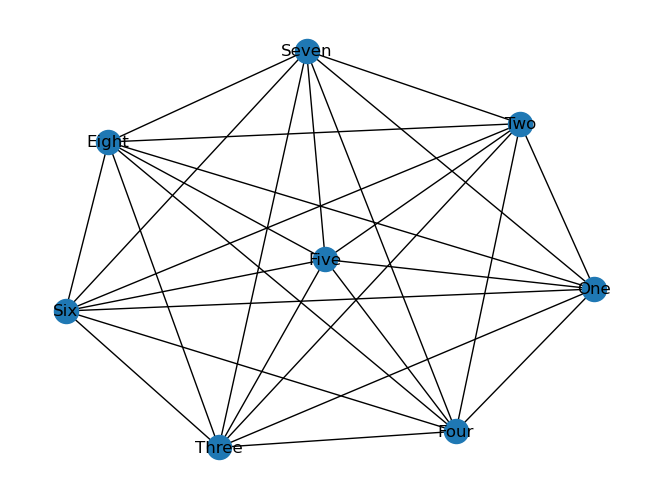

In [11]:
g = Graph(df_small)
print(g)
nx.draw(g, with_labels = True)

In [12]:
def PC_0(df, rho, G):
    '''
    finds 0th order conditional independencies (CI) between each node, if True then remove an edge 
    '''
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
    ind_0 = [x[:2] for x in chi2bool(df, rho)[0]]
    for i,j in ind_0:
        G.remove_edge(i,j)
#     print(G)
    return(G)

Graph with 8 nodes and 20 edges


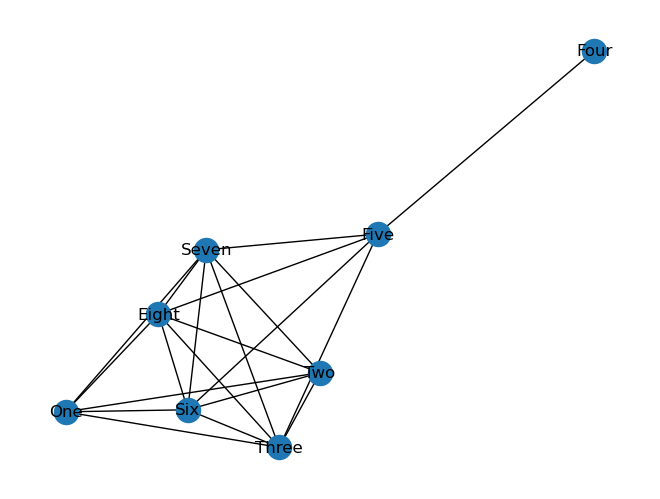

In [13]:
g_0 = PC_0(df_small, 0.05, g)
print(g_0)
nx.draw(g_0, with_labels = True)

In [43]:
find_adjacency_XY(g_0)

[('One', 'Two', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('One', 'Three', ['Two', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Six', ['Two', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Seven', ['Two', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('One', 'Eight', ['Two', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Two', 'Three', ['One', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Six', ['One', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Seven', ['One', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('Two', 'Eight', ['One', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Three', 'Five', ['One', 'Two', 'Six', 'Seven', 'Eight', 'Four'], 6),
 ('Three', 'Six', ['One', 'Two', 'Five', 'Seven', 'Eight'], 5),
 ('Three', 'Seven', ['One', 'Two', 'Five', 'Six', 'Eight'], 5),
 ('Three', 'Eight', ['One', 'Two', 'Five', 'Six', 'Seven'], 5),
 ('Four', 'Five', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('Five', 'Six', ['Three', 'Four', 'Seven', 'Eight', 'One', 'Two'], 6),
 ('Five', 'Seven', ['Three', 'Four', '

### adjacency finder

In [65]:
def find_adjacency_XY(graph):    
    test_list = []
    graph_list = list(graph.edges)
    for i,j in graph_list:
        test_list.append((i, j, list(graph.edges(i)), list(graph.edges(j))))
    n = 0
    N = len(test_list)
    edge_XY = []
    while n < N:
        ##
        adjacent_X = []
        adjacent_Y = []
        X, Y = test_list[n][0], test_list[n][1]
        k_X, k_Y = test_list[n][2], test_list[n][3]
        edge_X = [x for x in k_X if x[1] != Y]
        edge_Y = [x for x in k_Y if x[1] not in (y[1] for y in k_X) and x[1] != X]
        for x in edge_X:
            adjacent_X.append(x[1])
        for y in edge_Y:
            adjacent_Y.append(y[1])
        adjacent_XY = adjacent_X + adjacent_Y
        len_XY = len(adjacent_XY)
        edge_XY.append((X, Y, adjacent_XY, len_XY))
#         print(edge_XY)
        n += 1
    return edge_XY

In [66]:
adj = find_adjacency_XY(g_0)
adj

[('One', 'Two', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('One', 'Three', ['Two', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Six', ['Two', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Seven', ['Two', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('One', 'Eight', ['Two', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Two', 'Three', ['One', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Six', ['One', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Seven', ['One', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('Two', 'Eight', ['One', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Three', 'Five', ['One', 'Two', 'Six', 'Seven', 'Eight', 'Four'], 6),
 ('Three', 'Six', ['One', 'Two', 'Five', 'Seven', 'Eight'], 5),
 ('Three', 'Seven', ['One', 'Two', 'Five', 'Six', 'Eight'], 5),
 ('Three', 'Eight', ['One', 'Two', 'Five', 'Six', 'Seven'], 5),
 ('Four', 'Five', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('Five', 'Six', ['Three', 'Four', 'Seven', 'Eight', 'One', 'Two'], 6),
 ('Five', 'Seven', ['Three', 'Four', '

### obtaining combinations and data preprocessing

In [67]:
def get_combinations(this_list, N_0):
    '''
    get combinations of ONE list in ('One', 'Two', ['Three', 'Six', 'Seven', 'Eight'], 4) format
    '''
    adjacency = this_list[2]
    len_adjacency = len(adjacency)
    n = 1
    combinations = []
    while n <= N_0:
        k = list(itertools.combinations(adjacency, n))
        combinations.append(k)
        n += 1
    return [x for x in combinations if x != []]

In [68]:
def combinations_adjacents(adj, N):
    '''
    adj = output from find_adjacency_XY
    N = stopping point for how many combinations you want
    output: obtains the combinations of n=1,2,...N of the whole list in an unordered manner (see open_list)
    '''
    len_adjacents = len(adj)
    n = 0
    empty = []
    while n < len_adjacents:
        k = get_combinations(adj[n], N)
        empty.append((adj[n][0], adj[n][1], k))
        n += 1
    empty = [x for x in empty if x != []]
    return empty

In [69]:
def open_list(lists):
    '''
    lists = output from combinations_adjacents, the whole thing
    all this function does is concatenates the adjacents of different combinations together
    '''
    n = 0
    N = len(lists)
    output = []
    while n < N:
        t = list(itertools.chain.from_iterable(lists[n][2]))
        output.append((lists[n][0], lists[n][1], t))
        n += 1
    return output

In [70]:
# a = open_list(combinations)
opened = open_list(combinations)
# opened

### chi2 test 

In [71]:
def chi2_list(this_list, df, rho):
    '''
    performs chi2 test on 1 list in open_list format
    '''
    n = 0
    N = len(this_list[2])
    x = this_list[0]
    y = this_list[1]
    output = []
    while n < N:
        chi2 = chi_square(X=x, Y=y, Z=this_list[2][n], data=df, significance_level=rho)
        if chi2 == True:
            output.append(chi2)
            break
        n += 1
    return output

In [72]:
def PC_2(opened, df, rho):
    '''
    takes in the output from open_list()
    '''
    n = 0
    N = len(opened)
    output = []
    while n < N:
        chi2 = chi2_list(opened[n], df, rho)
        if True in chi2:
            output.append((opened[n][0], opened[n][1], opened[n][2][n], chi2))            
#             print(opened[n][0], opened[n][1], opened[n][2][n], chi2)
        n += 1
    return output

In [74]:
%%time
# opened[n][2][n]
ind = PC_2(opened, df_small, 0.05)
# opened[2][n][n]

CPU times: total: 4.88 s
Wall time: 5 s


In [75]:
for i in ind:
    G.

[('One', 'Six', ('Seven',), [True]),
 ('One', 'Seven', ('Eight',), [True]),
 ('One', 'Eight', ('Five',), [True]),
 ('Two', 'Three', ('One', 'Six'), [True]),
 ('Two', 'Seven', ('One', 'Eight'), [True]),
 ('Two', 'Eight', ('One', 'Five'), [True]),
 ('Three', 'Five', ('One', 'Eight'), [True]),
 ('Three', 'Six', ('Two', 'Seven'), [True]),
 ('Three', 'Seven', ('Two', 'Eight'), [True]),
 ('Five', 'Seven', ('Six', 'Eight'), [True]),
 ('Five', 'Eight', ('Six', 'One'), [True]),
 ('Seven', 'Eight', ('One', 'Three', 'Six'), [True])]

### small network

In [ ]:
m = Gobnilp()
m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat')